<a href="https://www.kaggle.com/code/hetarthchopra/neural-network-feature-selection?scriptVersionId=114469385" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This notebook is just a code run through for the tutorial at https://captum.ai/tutorials/Titanic_Basic_Interpret. 
I have used it to get up to speed with Captum, PyTorch and Model Interpretability. 

Apart from that, I will be building a model with all the features first, and then I will try to increase the accuracy after removin the less important features using Integrated Gradients Approach

In [2]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
!matplotlib.inline

from scipy import stats
import pandas as pd

/bin/bash: matplotlib.inline: command not found


In [4]:
# read the dataset
titanic_data = pd.read_csv('/kaggle/input/titanic/train.csv')
# do one hot encoding
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="pclass")], axis=1)
titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass','PassengerId'], axis=1)

In [5]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,embark_C,embark_Q,embark_S,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [6]:
#set random seed for reproducibility
np.random.seed(100)

# convert all to numpy
labels = titanic_data['Survived'].to_numpy()
titanic_data = titanic_data.drop(['Survived'],axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

In [7]:
# separate train and test data
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))  
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x,y):
        super().__init__()
        self.x = x
        self.y = y 
    
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

# define the train and test dataloader
train_loader = torch.utils.data.DataLoader(Dataset(train_features,train_labels))
test_loader = torch.utils.data.DataLoader(Dataset(test_features,test_labels))

## Build a Baseline Model

In [9]:
torch.manual_seed(1)

# code a neural network with the nn module imported into the class
class Titanic_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12,12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12,8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8,2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        lin1_out = self.linear1(x)
        sigmoid1_out = self.sigmoid1(lin1_out)
        lin2_out = self.linear2(sigmoid1_out)
        sigmoid2_out = self.sigmoid2(lin2_out)
        lin3_out = self.linear3(sigmoid2_out)
        softmax_out = self.softmax(lin3_out)
        return softmax_out

In [10]:
model = Titanic_Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
total_loss, total_acc = list(),list()
feat_imp = np.zeros(train_features.shape[1])
num_epochs = 200

for epoch in range(num_epochs):
    losses = 0 
    for idx, (x,y) in enumerate(train_loader):
        x,y = x.float(), y.type(torch.LongTensor)
        x.requires_grad=True
        optimizer.zero_grad()
        # check if the progrma can be run with model(x) and model.forward()
        preds=model.forward(x)
        loss=criterion(preds,y)
        x.requires_grad = False
        loss.backward()
        optimizer.step()
        losses+=loss.item()
    total_loss.append(losses/len(train_loader))
    if epoch%5==0:
        print("Epoch:", str(epoch+1), "\tLoss:", total_loss[-1])

Epoch: 1 	Loss: 0.6368781153596997
Epoch: 6 	Loss: 0.5438965893863292
Epoch: 11 	Loss: 0.517187478502145
Epoch: 16 	Loss: 0.5438799783467864
Epoch: 21 	Loss: 0.5004157700948119
Epoch: 26 	Loss: 0.4994503778209656
Epoch: 31 	Loss: 0.49501782502638203
Epoch: 36 	Loss: 0.5033017487338419
Epoch: 41 	Loss: 0.48362492060776124
Epoch: 46 	Loss: 0.48397618527397107
Epoch: 51 	Loss: 0.50594358469089
Epoch: 56 	Loss: 0.504416681359706
Epoch: 61 	Loss: 0.4826085575128252
Epoch: 66 	Loss: 0.4896238000396741
Epoch: 71 	Loss: 0.5042006650380492
Epoch: 76 	Loss: 0.4862840793201667
Epoch: 81 	Loss: 0.4927722219001041
Epoch: 86 	Loss: 0.4991834896047081
Epoch: 91 	Loss: 0.527817468438447
Epoch: 96 	Loss: 0.4846147484419625
Epoch: 101 	Loss: 0.5866930904778775
Epoch: 106 	Loss: 0.5093530062974743
Epoch: 111 	Loss: 0.48413032432046404
Epoch: 116 	Loss: 0.48877072597391913
Epoch: 121 	Loss: 0.48853638466824306
Epoch: 126 	Loss: 0.4779637341131942
Epoch: 131 	Loss: 0.48674786526165653
Epoch: 136 	Loss: 0.4

In [11]:
# save the model
torch.save(model.state_dict(), '/kaggle/working/titanic_model.pt')

In [12]:
model.eval()
correct=0
for idx, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        x,y = x.float(), y.type(torch.LongTensor)
        pred = model(x)
        preds_class = torch.argmax(pred)
        if (preds_class.numpy()== y.numpy()[0]):
            correct+=1
print("Accuracy = ", correct/len(test_indices))

Accuracy =  0.7350746268656716


In [13]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)

## Calculate the Integrated Gradients

In [14]:
ig = IntegratedGradients(model)

In [15]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, target = 1, return_convergence_delta  = True)
attr = attr.detach().numpy()

Average Feature Importances
Age :  0.717
SibSp :  0.109
Parch :  0.012
Fare :  0.180
female :  0.016
male :  0.393
embark_C :  0.024
embark_Q :  0.006
embark_S :  0.072
pclass_1 :  0.072
pclass_2 :  0.037
pclass_3 :  0.038


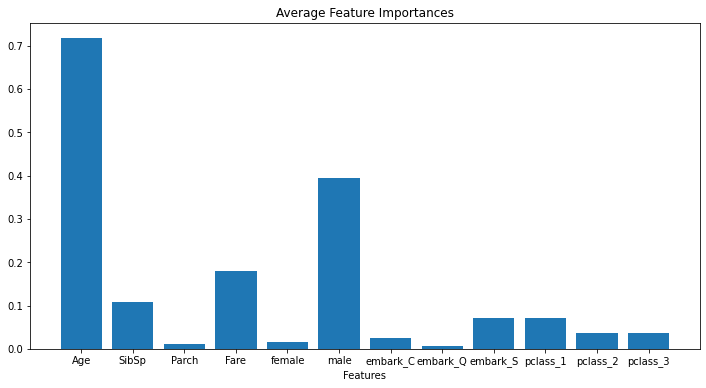

In [16]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(np.abs(attr), axis=0))

## Get Top K Least Important Features and Retrain

In [17]:
def make_new_dataset(features_to_be_dropped):
    # read the dataset
    titanic_data = pd.read_csv('/kaggle/input/titanic/train.csv')
    # do one hot encoding
    titanic_data = pd.concat([titanic_data,
                              pd.get_dummies(titanic_data['Sex']),
                              pd.get_dummies(titanic_data['Embarked'],prefix="embark"),
                              pd.get_dummies(titanic_data['Pclass'],prefix="pclass")], axis=1)
    titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
    titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())
    titanic_data = titanic_data.drop(['Name','Ticket','Cabin','Sex','Embarked','Pclass','PassengerId'], axis=1)
    titanic_data = titanic_data.drop(features_to_be_dropped, axis=1)
    # convert all to numpy
    labels = titanic_data['Survived'].to_numpy()
    titanic_data = titanic_data.drop(['Survived'],axis=1)
    feature_names = list(titanic_data.columns)
    data = titanic_data.to_numpy()
    # separate train and test data
    train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
    test_indices = list(set(range(len(labels))) - set(train_indices))
    train_features = data[train_indices]
    train_labels = labels[train_indices]
    test_features = data[test_indices]
    test_labels = labels[test_indices]
    # define the train and test dataloader
    train_loader = torch.utils.data.DataLoader(Dataset(train_features,train_labels))
    test_loader = torch.utils.data.DataLoader(Dataset(test_features,test_labels))
    return train_loader,test_loader

In [18]:
def define_model(k_features):
    torch.manual_seed(1)
    # code a neural network with the nn module imported into the class
    class Titanic_Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear1 = nn.Linear(12-k_features,12) # since features have been dropped chaneg input layer
            self.sigmoid1 = nn.Sigmoid()
            self.linear2 = nn.Linear(12,8)
            self.sigmoid2 = nn.Sigmoid()
            self.linear3 = nn.Linear(8,2)
            self.softmax = nn.Softmax(dim=1)

        def forward(self,x):
            lin1_out = self.linear1(x)
            sigmoid1_out = self.sigmoid1(lin1_out)
            lin2_out = self.linear2(sigmoid1_out)
            sigmoid2_out = self.sigmoid2(lin2_out)
            lin3_out = self.linear3(sigmoid2_out)
            softmax_out = self.softmax(lin3_out)
            return softmax_out
    return Titanic_Model 

In [19]:
def train_model(Titanic_Model):
    model = Titanic_Model()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    total_loss, total_acc = list(),list()
    feat_imp = np.zeros(train_features.shape[1])
    num_epochs = 200

    for epoch in range(num_epochs):
        losses = 0 
        for idx, (x,y) in enumerate(train_loader):
            x,y = x.float(), y.type(torch.LongTensor)
            x.requires_grad=True
            optimizer.zero_grad()
            # check if the progrma can be run with model(x) and model.forward()
            preds=model.forward(x)
            loss=criterion(preds,y)
            x.requires_grad = False
            loss.backward()
            optimizer.step()
            losses+=loss.item()
        total_loss.append(losses/len(train_loader))
        if epoch%20==0:
            print("Epoch:", str(epoch+1), "\tLoss:", total_loss[-1])
    return model

In [20]:
def test_results(model, test_loader):
    model.eval()
    correct=0
    for idx, (x,y) in enumerate(test_loader):
        with torch.no_grad():
            x,y = x.float(), y.type(torch.LongTensor)
            pred = model(x)
            preds_class = torch.argmax(pred)
            if (preds_class.numpy()== y.numpy()[0]):
                correct+=1
    print("Accuracy = ", correct/len(test_indices))
    return correct/len(test_indices)

In [21]:
feat_imp=  np.mean(np.abs(attr), axis=0)
[(a,b) for (a,b) in sorted(zip(feat_imp,feature_names))]

[(0.0063142482868198645, 'embark_Q'),
 (0.011894713774308433, 'Parch'),
 (0.01612300144291922, 'female'),
 (0.024265737128558507, 'embark_C'),
 (0.036532666549844856, 'pclass_2'),
 (0.03768915279681935, 'pclass_3'),
 (0.07236414869892333, 'embark_S'),
 (0.07240700622559684, 'pclass_1'),
 (0.10861852731388526, 'SibSp'),
 (0.1802384984484775, 'Fare'),
 (0.39329876578529344, 'male'),
 (0.7168488405390406, 'Age')]

In [22]:
best_accuracy = list()
for i in range(9):
    k_features=i
    features_to_be_dropped = [b for (a,b) in sorted(zip(feat_imp,feature_names))][0:k_features]
    print(features_to_be_dropped)
    train_loader,test_loader = make_new_dataset(features_to_be_dropped)
    Titanic_Model = define_model(k_features)
    trained_model = train_model(Titanic_Model)
    test_result = test_results(trained_model,test_loader)
    best_accuracy.append(test_result)

[]
Epoch: 1 	Loss: 0.6460997971734496
Epoch: 21 	Loss: 0.5093226923127427
Epoch: 41 	Loss: 0.5237532646468516
Epoch: 61 	Loss: 0.5101660966012107
Epoch: 81 	Loss: 0.4835971693357342
Epoch: 101 	Loss: 0.5114455263266403
Epoch: 121 	Loss: 0.5047322972341296
Epoch: 141 	Loss: 0.4893433764505157
Epoch: 161 	Loss: 0.47576824462050227
Epoch: 181 	Loss: 0.48246772087404854
Accuracy =  0.8134328358208955
['embark_Q']
Epoch: 1 	Loss: 0.629890263989496
Epoch: 21 	Loss: 0.510095078767207
Epoch: 41 	Loss: 0.5299258877435045
Epoch: 61 	Loss: 0.49604895466977483
Epoch: 81 	Loss: 0.5052380019837742
Epoch: 101 	Loss: 0.48662070975449073
Epoch: 121 	Loss: 0.4962478343690379
Epoch: 141 	Loss: 0.49624723157760225
Epoch: 161 	Loss: 0.49347122877023003
Epoch: 181 	Loss: 0.48966411832439
Accuracy =  0.8022388059701493
['embark_Q', 'Parch']
Epoch: 1 	Loss: 0.649799137015978
Epoch: 21 	Loss: 0.5222614167877032
Epoch: 41 	Loss: 0.49907063978632993
Epoch: 61 	Loss: 0.5061223811169497
Epoch: 81 	Loss: 0.48414097

In [23]:
print(max(best_accuracy))

0.835820895522388


# # # *We can see from here that the Test Accuracy increases as we use less features after feature selection.*